In [2]:
import itertools
import math
import trueskill as t
import numpy as np


class TrueSkill_classifier:
    def __init__(self, starting_skill = 0, starting_var = (25/3), BETA = 25/6):
        #starting skill is defenitly 0, starting var has to be determined
        self.st_skill = starting_skill
        self.st_var = starting_var
        self.BETA = BETA
        self.learners = {}
        


    def win_probability(self,team1, team2):
        delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
        sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
        size = len(team1) + len(team2)
        denom = math.sqrt(size * (self.BETA * self.BETA) + sum_sigma)
        ts = t.global_env()
        return ts.cdf(delta_mu / denom)

    
    
    def fit(self,X,y, bias = False):
        #each instance of X is its own team
        #each feature is its own player
        
        #initialise features
        if self.learners == {}:
            for i in range(X.shape[1]):
                self.learners[i] = t.Rating(self.st_skill,self.st_var)
        
        if bias == True:
            
            self.learners['B'] = t.Rating(self.st_skill,self.st_var)
            
        #iterate over rows
        for i in range(X.shape[0]):
            
            #print(X[i,:])
            active_features = np.where(X[i,:] == 1)[0]
            
            
                
            #print(active_features)
            
            team_features = [self.learners[i] for i in active_features]
            
            if bias == True:
                team_features.append(self.learners['B'])
                
            dummy_features = [t.Rating(0,1/10000) for i in active_features]
            if y[i] == 1:
                #lower rank is better!!!
                (team_features,_) = t.rate([team_features,dummy_features],ranks=[0,1])
            else:
                (team_features,_) = t.rate([team_features,dummy_features],ranks=[1,0])
                
                            
            #print(team_features[-1])
            
            for i in range(len(active_features)):
                    #print(active_features[i])
                self.learners[active_features[i]] = team_features[i]
            
            #update learners
            if bias == True:
                self.learners['B'] = team_features[-1]
                #print(self.learners['B'])
            
        return None
            
    
    
    
    def predict_proba(self,X):
        #prediction is evaluation of instance against dummy team
        
        #predicted vector (probability that first wins)
        y_pred = []
        for i in range(X.shape[0]):
            active_features = np.where(X[i,:] == 1)[0]

            team_features = [self.learners[i] for i in active_features]
            dummy_features = [t.Rating(0,1/10000) for i in active_features]
            
            y_pred.append(self.win_probability(team_features,dummy_features))
        return y_pred
    
    def predict(self,X):
        y_proba = self.predict_proba(X)
        
        return([1 if i > 0.5 else 0 for i in y_proba])
        
        

In [3]:
learner = TrueSkill_classifier()

In [4]:
learner.fit(np.array([[0,1,1,1,0]]),[1])

In [5]:
learner.learners

{0: trueskill.Rating(mu=0.000, sigma=8.333),
 1: trueskill.Rating(mu=3.318, sigma=7.706),
 2: trueskill.Rating(mu=3.318, sigma=7.706),
 3: trueskill.Rating(mu=3.318, sigma=7.706),
 4: trueskill.Rating(mu=0.000, sigma=8.333)}

In [6]:
learner.predict_proba(np.array([[0,1,1,1,0]]))


[0.7232203947847158]

In [7]:
X = np.random.randint(2,size = (10,200))
y = np.random.randint(2,size = (1,200))[0]

In [8]:
people = []
for i in range(10):
    learner = TrueSkill_classifier()
    learner.fit(X,y)
    people.append(learner)

In [9]:
import operator
import scipy.stats as stats
def display(learner):
    #user = User.objects.get(username=name)
    #learner = Serial.parm_to_skill(user.userinfo.params[0])
    x = np.linspace(-5, 5, 100)
    y = []

    l = learner.learners
    mu = {i: l[i].mu for i in l.keys()}
    sigma = {i: l[i].sigma for i in l.keys()}
    sorted_mu = sorted(mu.items(), key=operator.itemgetter(1))
    sorted_sigma = sorted(sigma.items(), key=operator.itemgetter(1))
    for i in range(len(sorted_mu)):
        mu = sorted_mu[i][1]
        variance = sorted_sigma[i][1]
        sigma = math.sqrt(variance)
        y.append(stats.norm.pdf(x, mu, sigma))

    return([list(x), list(y)])

In [10]:
len(display(people[0]))

2

In [11]:
attributes = {
'Perception' : {
'Text alternatives':{},
'Time-based media':{},
'Adaptability':{},
'Distinguishability':{}
},
'Operability' : {
'Keyboard accessibility':{},
'Time limitation':{},
'Navigation':{}
},
'Understandability' :{
'Readability':{},
'Predictability':{},
'Help with input':{}
}  
}

In [12]:
people[0].learners[0].mu

-0.5564106228808205

In [13]:
import copy
def learners_to_dict(learners):
    i = 0
    user_attributes = copy.deepcopy(attributes)
    for topic in attributes.keys():
        for feature in attributes[topic].keys():
            user_attributes[topic][feature] = {}
            for value in range(4):
                user_attributes[topic][feature][value] = {'mu' : learners[i].mu, 'sigma' : learners[i].sigma}
                i += 1
    return user_attributes

In [14]:
import annotate_learners as al
a_l = al.annotate_learner(people[0].learners)
a_l['Perception']

{'Text alternatives': {0: {'mu': -0.5564106228808205,
   'sigma': 8.2067464147114},
  1: {'mu': 0.6175577565235726, 'sigma': 8.225033216405278},
  2: {'mu': 0.7170652958000077, 'sigma': 8.261869719933179},
  3: {'mu': 0.6984729669453631, 'sigma': 8.263320879900277}},
 'Time-based media': {0: {'mu': 0.35321027008873745,
   'sigma': 8.278396266064263},
  1: {'mu': 0.3330249069778314, 'sigma': 8.228848880002818},
  2: {'mu': -1.2400156260409556, 'sigma': 8.235196182249982},
  3: {'mu': 0.577615870013855, 'sigma': 8.315431748407095}},
 'Adaptability': {0: {'mu': 1.5609002819864843, 'sigma': 8.281097198338903},
  1: {'mu': 1.3159791268256715, 'sigma': 8.19070656669265},
  2: {'mu': 1.0114288964364686, 'sigma': 8.297298931700878},
  3: {'mu': -1.8600044016925812, 'sigma': 8.254544045172304}},
 'Distinguishability': {0: {'mu': 0.589298048002976,
   'sigma': 8.259636381945228},
  1: {'mu': 0.6134161600428529, 'sigma': 8.259622316962417},
  2: {'mu': 1.2477126165346584, 'sigma': 8.2450011461392

In [15]:
def return_biggest_value_mu(feature_dict):
    max_value = list(feature_dict.keys())[0]
    max_mu = 0
    max_sigma = 0
    for value in feature_dict.keys():
        if abs(feature_dict[value]['mu']) > abs(feature_dict[max_value]['mu']):
            max_value = value
            max_mu = feature_dict[value]['mu']
            max_sigma = feature_dict[value]['sigma']
    return {'max_value':value, 'mu':max_mu, 'sigma':max_sigma}

In [17]:
al.player_summary(people[1].learners)

[['Perception', 'Operability', 'Understandability'],
 [{'max_value': 3, 'mu': 1.2731243998935642, 'sigma': 8.24588111913312},
  {'max_value': 3, 'mu': 1.2525964496465485, 'sigma': 8.247534474620243},
  {'max_value': 3, 'mu': 2.177594421102581, 'sigma': 8.26155720424113}]]

In [16]:
return_biggest_value_mu(a_l['Perception']['Distinguishability'])

{'max_value': 3, 'mu': 0, 'sigma': 0}

In [17]:
def return_summary_gaussian(annotated_dict):
    summary = {}
    for topic in annotated_dict.keys():
        summary[topic] = {}
        biggest_mu = 0
        for feature in annotated_dict[topic].keys():
            feature_dict = return_biggest_value_mu(annotated_dict[topic][feature])
            
            if abs(feature_dict['mu']) > abs(biggest_mu):
                summary[topic] = feature_dict
    return(summary)

In [18]:
return_summary_gaussian(a_l)

{'Perception': {'max_value': 3,
  'mu': 0.5067848330214965,
  'sigma': 8.236345645451074},
 'Operability': {'max_value': 3,
  'mu': 2.1250547115557126,
  'sigma': 8.250793607014488},
 'Understandability': {'max_value': 3,
  'mu': 2.5894606959934103,
  'sigma': 8.225144015594239}}

In [19]:
learners_to_dict(people[0].learners)

{'Perception': {'Text alternatives': {0: {'mu': -0.443409494723795,
    'sigma': 8.262375992294555},
   1: {'mu': 1.5351564065273866, 'sigma': 8.24703006751618},
   2: {'mu': 2.3794182946565012, 'sigma': 8.247235602224679},
   3: {'mu': 0.12795298409881664, 'sigma': 8.301719577021892}},
  'Time-based media': {0: {'mu': 1.2223169220642662,
    'sigma': 8.273011985128838},
   1: {'mu': 0.2988854926848846, 'sigma': 8.266803935165335},
   2: {'mu': 1.7343635949038192, 'sigma': 8.281161880313315},
   3: {'mu': 0.3614934338061148, 'sigma': 8.272279680718896}},
  'Adaptability': {0: {'mu': 0.28018688648482615, 'sigma': 8.24988836356247},
   1: {'mu': -0.07835861306685317, 'sigma': 8.215274121465352},
   2: {'mu': 0.5067848330214965, 'sigma': 8.236345645451074},
   3: {'mu': 0.2978753260954983, 'sigma': 8.232338155297017}},
  'Distinguishability': {0: {'mu': -1.6201393694886297,
    'sigma': 8.252650465838821},
   1: {'mu': 0.9445541302297956, 'sigma': 8.226005903841916},
   2: {'mu': 0.298008

In [20]:
def getz(self,request,user):
    learners = user.learners
    i = 0
    user_attributes = copy.deepcopy(attributes)
    for topic in attributes.keys():
        for feature in attributes[topic].keys():
            user_attributes[topic][feature] = {}
            for value in range(4):
                user_attributes[topic][feature][value] = {'mu' : learners[i].mu, 'sigma' : learners[i].sigma}
                i += 1
    return(Response(user_attributes))

In [21]:
learners_to_dict(people[0], attributes)

TypeError: learners_to_dict() takes 1 positional argument but 2 were given

In [ ]:
attributes

In [ ]:
reprs = []
for i in people:
    rep = []
    for j in i.learners:
        rep.append(i.learners[j].mu)
    reprs.append(rep)

In [ ]:
type(reprs)

In [ ]:
reprs = np.array(reprs)

In [ ]:
reprs.shape

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, method = 'exact')

In [ ]:
tsne = tsne.fit(all_users)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(tsne.embedding_[:,0],tsne.embedding_[:,1])

In [ ]:
tsne.embedding_[:,0]

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
GM = BayesianGaussianMixture(n_components = 4, max_iter = 200)
GM = GM.fit(reprs)
print(GM.weights_)
GM.predict(reprs)

In [ ]:
import SpeculativeRepresentation as SR
SR.speculative_induction_pozitive([0,2,3,3,2],3)

In [ ]:
SR.speculative_induction_negative([0,2,3,3,2])

In [ ]:
import operator
x = people[0].learners
sorted_x = sorted(x.items(), key=operator.itemgetter(1))

In [ ]:
import operator
mu = {i:x[i].mu for i in x.keys()}
sigma = {i:x[i].sigma for i in x.keys()}
sorted_mu = sorted(mu.items(), key=operator.itemgetter(1))
sorted_sigma = sorted(sigma.items(), key=operator.itemgetter(1))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
for i in range(len(sorted_mu)):
    mu = sorted_mu[i][1]
    variance = sorted_sigma[i][1]
    sigma = math.sqrt(variance)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

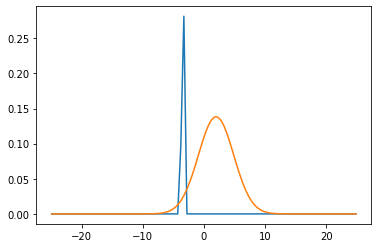

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

x = np.linspace(-3*8.3,3*8.3, 100)
for i,j in [(-3.5,0.01), (2, 8.3)]:
    mu = i
    variance = j
    sigma = math.sqrt(variance)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [ ]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

In [ ]:
stats.norm.pdf(x, mu, sigma)

In [ ]:
n_of_attributes = 4 + 3 + 3
n_of_values = 4

In [ ]:
def skill_to_parm(TrueSkillObject):
    parms = []
    for i in TrueSkillObject.learners.keys():
        parms.append([TrueSkillObject.learners[i].mu,TrueSkillObject.learners[i].sigma])
    return parms

def parm_to_skill(parms):
    skill = TrueSkill_classifier()
    for i in range(len(parms)):
        skill.learners[i] = t.Rating(parms[i][0],parms[i][1])
    return skill

In [ ]:
skill_to_parm(learner)

In [ ]:
np.random.normal(mu, sigma, 1)

In [ ]:
def generate_users(N):
    users = {}
    for i in range(N):
        users['AutoGenerated{}'.format(i)] = [[np.random.normal(0, 0.5, 1)[0],np.random.normal(6,0.5,1)[0]] 
                                              for i in range(n_of_attributes*n_of_values)]
    return users

In [ ]:
import GenerateUsers as G

In [ ]:
G.generate_users(100)

In [ ]:
questions = ['Text alternatives: how much non-text content has text alternatives:',
            'Time-based media: now much of time based media has alternatives:',
             'Adaptability: is content presented in a simplified way that is compatible with a screen reader:',
            'Distinguishability: is viewing of web content simplified for the user:',
             'Keyboard accessibility: is the web content accessible with the keyboard:',
             'Time limitation for interacting with the web content: is interaction with the web site time limited:',
             'Navigation: does the website support easy navigation:',
            'Readability: is the content readable and understandable:',
             'Predictability: are web sites organized in a logical and predictable way:',
             'Help with input: Web site automatically detects and corrects input mistakes from the user:'
            ]

In [ ]:
questions_options = {'Text alternatives: how much non-text content has text alternatives':[
'AAA: all non-text content has text alternatives'
'AA: majority of non-text content has text alternatives'
'A: some non-text content has text alternatives'
'Non-compliant: no text alternatives are provided'
],

'Time-based media: now much of time based media has alternatives':[
'AAA: all non-text content has text alternatives'
'AA: majority of non-text content has text alternatives'
'A: some non-text content has text alternatives'
'Non-compliant: no text alternatives are provided'
],

'Adaptability: is content presented in a simplified way that is compatible with a screen reader':[
'AAA: all content is presented in a simplified way'
'AA: majority of content is presented in a simplified way'
'A: only a small fraction of content is presented in a simplified way'
'Non-compliant: no content is presented in a simplified way'
],

'Distinguishability: is viewing of web content simplified for the user':[
'AAA: foreground and background color can be modified'
'AA: Sound management mechanism is separated from system for web site navigation'
'A: colors do not carry information'
'Non-compliant: content is nod made easily distinguishable for the user'
],


'Keyboard accessibility: is the web content accessible with the keyboard':[
'AAA: the whole web site is accessible with the keyboard'
'AA: most of the web site is accessible with the keyboard'
'A: main parts of web site are accessible with the keyboard'
'Non-compliant: web content is completely inaccessible with the keyboard'
],

'Time limitation for interacting with the web content: is interaction with the web site time limited':[
'AAA: web site contains no time limited content'
'AA: user has the possibility to set speed of time limited content for all time limited content'
'A: user has the possibility to set speed for most of time limited content'
'Non-compliant: web content requires a lot of time-limited interaction'
],
'Navigation: does the website support easy navigation':[
'AAA: purpose and location (inside the same web site/outside) is clear from the name of the link'
'AA: web content supports different ways to navigate to it'
'A: navigation sequence between web contents is logical and intuitive'
'Non-compliant: navigation on the web content is difficult and unintuitive'
],

'Readability: is the content readable and understandable':[
'AAA: the content has support for different levels of reading (simplified versions of content are available)'
'AA: All parts of web content (if applicable) have marked the language in which they are written'
'A: It is marked in which language the web site is written'
'Non-compliant: web content is written in different languages and is written in difficult to understand style'
],

'Predictability: are web sites organized in a logical and predictable way':[
'AAA: Bigger changes to the user interface that happen automatically can be disabled'
'AA: Navigation of the website is consistent across all parts of the website'
'A: Changes to the user interface do not happen automatically'
'Non-compliant: interaction of web site with the user is inherently unpredictable'
],

'Help with input: Web site automatically detects and corrects input mistakes from the user':[
'AAA: Web site provides context aware help with instructions and recommendations for input'
'AA: In case the user makes an input mistake web site automatically suggests corrections'
'A: Web site automatically detects input mistake'
'Non-compliant: there is no help with user input'
]}

In [ ]:
questions_options.keys()

In [ ]:
from Questions import get_questions

In [ ]:
get_questions()

In [ ]:
# generate vectors sampled from mixed Gaussians
#blind users
import matplotlib.pyplot as plt
import numpy as np
mean = list(0.8 * np.ones((1,10))[0])+ list(0* np.ones((1,30))[0])
cov = np.diag(mean)


blind_means = np.random.multivariate_normal(mean, cov, 50)

partial_blind_1_mean = list(0.8 * np.ones((1,10))[0])+ list(0* np.ones((1,30))[0])
partial_blind_2_mean = list(0* np.ones((1,20))[0]) + list(0.8 * np.ones((1,10))[0])+ list(0* np.ones((1,10))[0])
partial_blind_3_mean = list(0* np.ones((1,30))[0]) + list(0.8 * np.ones((1,10))[0])

partial_blind_1_mean = np.random.multivariate_normal(partial_blind_1_mean, cov, 50)
partial_blind_2_mean = np.random.multivariate_normal(partial_blind_2_mean, cov, 50)
partial_blind_3_mean = np.random.multivariate_normal(partial_blind_3_mean, cov, 50)

In [ ]:
all_users = np.concatenate([blind_means, partial_blind_1_mean, partial_blind_2_mean, partial_blind_3_mean],axis=0)

In [ ]:
for i in [blind_means, partial_blind_1_mean, partial_blind_2_mean, partial_blind_3_mean]: print(i.shape)

In [ ]:
all_users.shape

In [ ]:
#generate users from mixed gaussian
all_users.shape

In [ ]:
variances = np.random.normal(8.3,0.5, (200, 40))

In [ ]:
variances

In [ ]:
final_matrix = []
for i in range(all_users.shape[0]):
    user = []
    for j in range(all_users.shape[1]):
        user.append([all_users[i,j],variances[i,j]])
    final_matrix.append(user)

In [ ]:
final_matrix

In [ ]:
import json
with open("users.json","w") as f:
    json.dump(final_matrix, f)